In [1]:
import sys
import os
from scipy.io import wavfile
import numpy as np
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.init import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.updates import *
import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline
import scipy

//anaconda/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
%load_ext rpy2.ipython

In [3]:
os.environ["DATA_DIR"] = "/Volumes/CB_RESEARCH/vocal_synthesis"
data_folder = os.environ["DATA_DIR"]

In [8]:
ctr = np.load(data_folder + os.path.sep + "x0.25_10_all_offset5_fft_std.npy.sample.npz")
#X_train = ctr.reshape( (1, X_train.shape[0], X_train.shape[1]))
#X_train.shape
X_train, X_valid, X_test = ctr["arr_0"], ctr["arr_1"], ctr["arr_2"]
X_train.shape

(100, 40, 8000)

In [26]:
args = dict()
args["seed"] = 0
args["batch_size"] = 128
args["learning_rate"] = 0.01
args["momentum"] = 0.9
args["num_epochs"] = 4000
args["X_train"] = X_train
args["X_valid"] = X_train
args["X_test"] = X_train
args["update_method"] = rmsprop
#args["out_pkl"] = out_pkl
args["units"] = [600]
#args["out_nonlinearity"] = "sigmoid"
args["forget_gate"] = 1.0

args["config"] = "../configurations/19mar_variable_3.py"

In [27]:
sys.path.append("..")
import rnn_experiment as exp
symbols = exp.prepare(args)
out_fn = symbols["out_fn"]
l_out = symbols["l_out"]
with open(data_folder + os.path.sep + "expensive_models" + os.path.sep + \
          "x0.25_10_all_offset5_fft_std/19mar_600x1.model") as f:
    model = pickle.load(f)
set_all_param_values(l_out, model)

loading config: ../configurations/19mar_variable_3.py
test...
using forget gate init with value = 1Number of params in model: 25453400
<lasagne.layers.input.InputLayer object at 0x10bcadc50>,(None, None, 8000)
<lasagne.layers.recurrent.LSTMLayer object at 0x12a5a13d0>,(None, None, 600)
<lasagne.layers.shape.ReshapeLayer object at 0x12a5a12d0>,(None, 600)
<lasagne.layers.dense.DenseLayer object at 0x1298e6250>,(None, 8000)
<lasagne.layers.shape.ReshapeLayer object at 0x12aaa0b10>,(None, None, 8000)


In [28]:
std = 23.988609

In [29]:
x_size = 4000

In [36]:
generated_seq = X_train[0:1].flatten().tolist()
generated_seq_array = []
# x1, x2, ..., x40
for i in range(0, X_train.shape[1]):
    generated_seq_array.append(X_train[0:1, i, :][0])
ctr = 0
for x in range(0, 30):
    #this_input = np.asarray(generated_seq_array[ctr::])
    this_input = np.asarray(generated_seq_array) # since we have var sequence lengths now
    this_input = this_input.reshape( (1, this_input.shape[0], this_input.shape[1]))
    
    #print this_input.shape
    #assert this_input.shape == (1, 100, 800)
    
    # (1, 40, 4000) -> (40, 4000) -> get last elem
    # predict x2, x3, ..., x41
    # then append x41 to generated_seq_array
    # now next time, feed [x2, x3, ..., x41] to out_fn to get
    # [x3, x4, ... x42]
    this_out = out_fn(this_input)[0][-1]
    assert this_out.shape == (x_size*2,)
    #print this_out.shape
    
    generated_seq_array.append(this_out)
    
    ctr += 1

In [37]:
len(generated_seq_array)

70

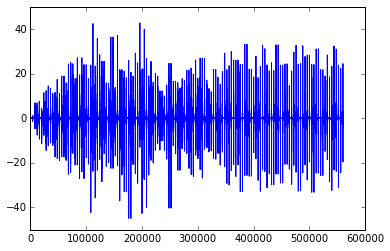

In [38]:
plt.plot(np.asarray(generated_seq_array).flatten())

In [39]:
new_generated_seq_array = []
for i in range(0, len(generated_seq_array)):
    this_seq = np.array(generated_seq_array[i], copy=True)
    # unnormalise the real elements
    this_seq = this_seq*x_size*std
    # now do the inverse fft transform
    new_generated_seq_array.append( scipy.ifft(this_seq[0:x_size] + 1j*this_seq[x_size::]).real )

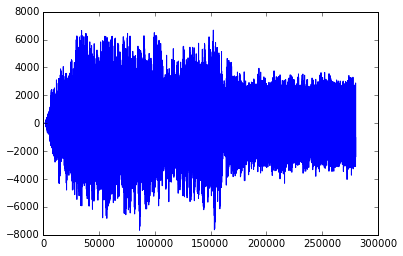

In [40]:
new_generated_seq = np.asarray(new_generated_seq_array).flatten()
plt.plot(new_generated_seq)

In [41]:
out_file = "/tmp/fft.wav"
wavfile.write(filename=out_file, rate=fs, data=new_generated_seq.astype("int16"))

----

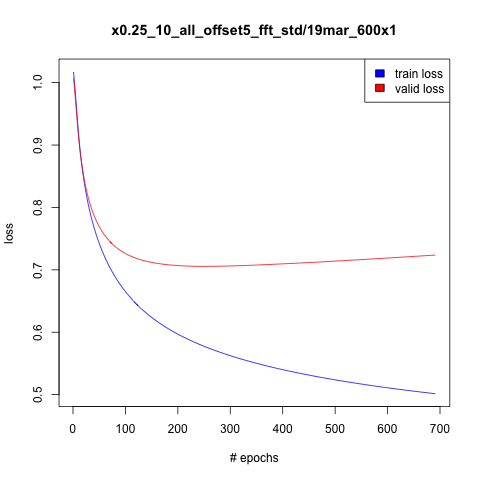

In [44]:
%%R
df = read.csv("../models/x0.25_10_all_offset5_fft_std/19mar_600x1.txt")

plot(df$train_loss, type="l", xlab="# epochs", ylab="loss", col="blue", main="x0.25_10_all_offset5_fft_std/19mar_600x1")
lines(df$valid_loss, type="l", col="red")
legend("topright", legend=c("train loss", "valid loss"), fill=c("blue", "red"))

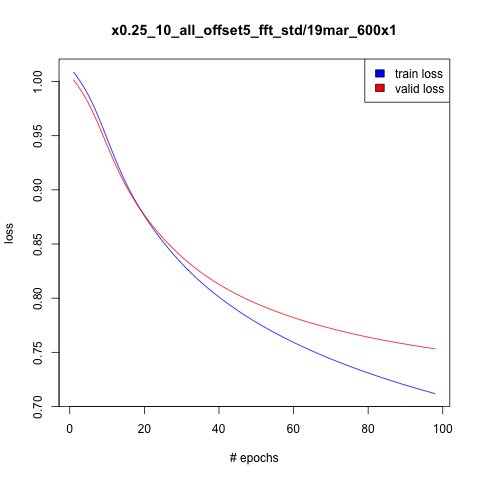

In [45]:
%%R
df = read.csv("../models/x0.25_10_all_offset5_fft_std/19mar_300x1.txt")

plot(df$train_loss, type="l", xlab="# epochs", ylab="loss", col="blue", main="x0.25_10_all_offset5_fft_std/19mar_600x1")
lines(df$valid_loss, type="l", col="red")
legend("topright", legend=c("train loss", "valid loss"), fill=c("blue", "red"))